# Project 4: WeRateDogs data wrangling

## Table of contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul>
        <li><a href="#gathering">Data gathering</a></li>
        <li><a href="#assessment">Data assessment</a></li>
        <li><a href="#cleaning">Data cleaning</a></li>
        <li><a href="#storing">Data storing</a></li>
    </ul>
<li><a href="#av">Analysis and Visualization</a></li>
</ul>

<a id='intro'></a>
## Introduction 

In this project, we will be wrangling, analysing and visualizing  the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). After gathering this data from Twitter's api (with [Tweepy](https://www.tweepy.org/)), we will be assessing and cleaning it. Finally, we will be finding useful insights from our cleaned data and producing some visualizations.

<a id='wrangling'></a>
## Data wrangling 

In [125]:
# importing libraries
import pandas as pd
import numpy as np
import tweepy 
import os
import time
import json
import requests
from PIL import Image
from io import BytesIO
import sqlite3

<a id='gathering'></a>
### Data gathering

#### `1.` WeRateDogs archive

In [126]:
# load WeRateDogs archive into dataframe
archive = pd.read_csv('../data/twitter-archive-enhanced.csv')
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### `2.` Tweets' image predictions.

In [127]:
# download 'image_predictions.tsv' into data folder
folder_path = '../data'
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open(os.path.join(folder_path, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)        

In [128]:
# check if file in data folder
os.listdir(folder_path)

['twitter_archive_master.csv',
 'image-predictions.tsv',
 'we-rate-dogs.db',
 'twitter-archive-enhanced.csv',
 'image_predictions_master.csv',
 'tweet_json.txt']

In [129]:
# load 'image_predictions.tsv' into dataframe
image_predictions = pd.read_csv('../data/image-predictions.tsv', sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### `3.` Retweet count and favorite count.

In [130]:
# WeRateDogs tweet ids
tweet_id_list = list(archive.tweet_id)
tweet_id_list

[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888202515573088257,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886267009285017600,
 886258384151887873,
 886054160059072513,
 885984800019947520,
 885528943205470208,
 885518971528720385,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884247878851493888,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046

In [131]:
# retrieve api credential from we-rate-dogs sqlite database located in ../data/we-rate-dogs.db
 
db = sqlite3.connect('../data/we-rate-dogs.db')
cursor = db.execute('SELECT * FROM auth;')
auth_args = []
for consumer_key, consumer_secret, access_token, access_secret in cursor.fetchall():
    auth_args.append((consumer_key, consumer_secret, access_token, access_secret))

In [132]:
# instantiate a tweepy object 

auth = tweepy.OAuthHandler(auth_args[0][0], auth_args[0][1])
auth.set_access_token(auth_args[0][2], auth_args[0][3])

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [133]:
# File path to save tweets' content
tweet_json_path = '../data/tweet_json.txt'
try:
    os.remove(tweet_json_path)
except: 
    pass
# Quering twitter ids in 'twitter_ids_list'
for tweet_id in tweet_id_list: 
    try:
        start_time = time.time() # start timing request 
        tweet = api.get_status(tweet_id, tweet_mode="extended")
        end_time = time.time() # end timing request
        print(f" Sucess! Tweet id: {tweet_id}. Request duration: {end_time - start_time}") 
        # Writing Twitter Json file into ../data/tweet_json.txt file.
        tweet_json =[]
        tweet_json.append({tweet.id: f'{tweet.retweet_count} {tweet.favorite_count}'}) 
        with open(tweet_json_path, mode='a', encoding='utf-8') as file:
            json.dump(tweet_json[0], file)
            file.write("\n")
    except:
        print(f"⚠️ Fail ⚠️ Tweet associated with the id {tweet_id} has been deleted")


 Sucess! Tweet id: 892420643555336193. Request duration: 5.831188440322876
 Sucess! Tweet id: 892177421306343426. Request duration: 0.7824039459228516
 Sucess! Tweet id: 891815181378084864. Request duration: 0.7799673080444336
 Sucess! Tweet id: 891689557279858688. Request duration: 0.8000271320343018
 Sucess! Tweet id: 891327558926688256. Request duration: 0.8026010990142822
 Sucess! Tweet id: 891087950875897856. Request duration: 0.8111486434936523
 Sucess! Tweet id: 890971913173991426. Request duration: 0.8360357284545898
 Sucess! Tweet id: 890729181411237888. Request duration: 0.8085813522338867
 Sucess! Tweet id: 890609185150312448. Request duration: 0.813784122467041
 Sucess! Tweet id: 890240255349198849. Request duration: 0.7512376308441162
 Sucess! Tweet id: 890006608113172480. Request duration: 0.7747616767883301
 Sucess! Tweet id: 889880896479866881. Request duration: 0.8188745975494385
 Sucess! Tweet id: 889665388333682689. Request duration: 0.8307783603668213
 Sucess! Tweet

 Sucess! Tweet id: 871166179821445120. Request duration: 0.8745462894439697
 Sucess! Tweet id: 871102520638267392. Request duration: 0.8761522769927979
 Sucess! Tweet id: 871032628920680449. Request duration: 0.8517625331878662
 Sucess! Tweet id: 870804317367881728. Request duration: 0.8237471580505371
 Sucess! Tweet id: 870726314365509632. Request duration: 0.8658921718597412
 Sucess! Tweet id: 870656317836468226. Request duration: 0.7987101078033447
 Sucess! Tweet id: 870374049280663552. Request duration: 0.8555192947387695
 Sucess! Tweet id: 870308999962521604. Request duration: 0.83217453956604
 Sucess! Tweet id: 870063196459192321. Request duration: 0.869032621383667
⚠️ Fail ⚠️ Tweet associated with the id 869988702071779329 has been deleted
 Sucess! Tweet id: 869772420881756160. Request duration: 0.8306334018707275
 Sucess! Tweet id: 869702957897576449. Request duration: 0.8197124004364014
 Sucess! Tweet id: 869596645499047938. Request duration: 0.8360702991485596
 Sucess! Tweet 

 Sucess! Tweet id: 850333567704068097. Request duration: 1.0451927185058594
 Sucess! Tweet id: 850145622816686080. Request duration: 0.9977335929870605
 Sucess! Tweet id: 850019790995546112. Request duration: 0.980344295501709
 Sucess! Tweet id: 849776966551130114. Request duration: 0.9682295322418213
 Sucess! Tweet id: 849668094696017920. Request duration: 0.9265906810760498
 Sucess! Tweet id: 849412302885593088. Request duration: 1.0249145030975342
 Sucess! Tweet id: 849336543269576704. Request duration: 0.915513277053833
 Sucess! Tweet id: 849051919805034497. Request duration: 0.9176273345947266
 Sucess! Tweet id: 848690551926992896. Request duration: 1.0096068382263184
 Sucess! Tweet id: 848324959059550208. Request duration: 0.8279595375061035
 Sucess! Tweet id: 848213670039564288. Request duration: 1.0218040943145752
 Sucess! Tweet id: 848212111729840128. Request duration: 0.9240870475769043
 Sucess! Tweet id: 847978865427394560. Request duration: 1.0180773735046387
 Sucess! Tweet

 Sucess! Tweet id: 833732339549220864. Request duration: 1.2295453548431396
 Sucess! Tweet id: 833722901757046785. Request duration: 1.1178441047668457
 Sucess! Tweet id: 833479644947025920. Request duration: 1.046403169631958
 Sucess! Tweet id: 833124694597443584. Request duration: 1.1000759601593018
 Sucess! Tweet id: 832998151111966721. Request duration: 1.1211011409759521
 Sucess! Tweet id: 832769181346996225. Request duration: 1.2462809085845947
 Sucess! Tweet id: 832757312314028032. Request duration: 1.0040438175201416
 Sucess! Tweet id: 832682457690300417. Request duration: 1.1414070129394531
 Sucess! Tweet id: 832645525019123713. Request duration: 1.205756425857544
 Sucess! Tweet id: 832636094638288896. Request duration: 1.008307695388794
 Sucess! Tweet id: 832397543355072512. Request duration: 0.9262416362762451
 Sucess! Tweet id: 832369877331693569. Request duration: 0.9665212631225586
 Sucess! Tweet id: 832273440279240704. Request duration: 0.9701399803161621
 Sucess! Tweet 

 Sucess! Tweet id: 820314633777061888. Request duration: 0.8822004795074463
 Sucess! Tweet id: 820078625395449857. Request duration: 0.8138687610626221
 Sucess! Tweet id: 820013781606658049. Request duration: 0.8372182846069336
 Sucess! Tweet id: 819952236453363712. Request duration: 5.838089227676392
 Sucess! Tweet id: 819924195358416896. Request duration: 0.8133361339569092
 Sucess! Tweet id: 819711362133872643. Request duration: 0.8432974815368652
 Sucess! Tweet id: 819588359383371776. Request duration: 0.8536508083343506
 Sucess! Tweet id: 819347104292290561. Request duration: 0.8730325698852539
 Sucess! Tweet id: 819238181065359361. Request duration: 0.8409476280212402
 Sucess! Tweet id: 819227688460238848. Request duration: 0.8556199073791504
 Sucess! Tweet id: 819015337530290176. Request duration: 0.8844740390777588
 Sucess! Tweet id: 819015331746349057. Request duration: 0.8603200912475586
 Sucess! Tweet id: 819006400881917954. Request duration: 0.8257215023040771
 Sucess! Twee

 Sucess! Tweet id: 805932879469572096. Request duration: 0.7894201278686523
 Sucess! Tweet id: 805826884734976000. Request duration: 0.8194460868835449
 Sucess! Tweet id: 805823200554876929. Request duration: 0.8190710544586182
 Sucess! Tweet id: 805520635690676224. Request duration: 0.8067994117736816
 Sucess! Tweet id: 805487436403003392. Request duration: 0.847090482711792
 Sucess! Tweet id: 805207613751304193. Request duration: 0.8619346618652344
 Sucess! Tweet id: 804738756058218496. Request duration: 0.7922654151916504
 Sucess! Tweet id: 804475857670639616. Request duration: 0.8238310813903809
 Sucess! Tweet id: 804413760345620481. Request duration: 0.7854547500610352
 Sucess! Tweet id: 804026241225523202. Request duration: 0.8372964859008789
 Sucess! Tweet id: 803773340896923648. Request duration: 0.8417832851409912
 Sucess! Tweet id: 803692223237865472. Request duration: 0.7875840663909912
 Sucess! Tweet id: 803638050916102144. Request duration: 0.795166015625
 Sucess! Tweet id

 Sucess! Tweet id: 792050063153438720. Request duration: 0.8427486419677734
 Sucess! Tweet id: 791821351946420224. Request duration: 0.8856198787689209
 Sucess! Tweet id: 791784077045166082. Request duration: 0.8364479541778564
 Sucess! Tweet id: 791780927877898241. Request duration: 0.8211629390716553
 Sucess! Tweet id: 791774931465953280. Request duration: 0.8378391265869141
 Sucess! Tweet id: 791672322847637504. Request duration: 0.922590970993042
 Sucess! Tweet id: 791406955684368384. Request duration: 0.8610401153564453
 Sucess! Tweet id: 791312159183634433. Request duration: 0.8670690059661865
 Sucess! Tweet id: 791026214425268224. Request duration: 0.8963320255279541
 Sucess! Tweet id: 790987426131050500. Request duration: 0.8347711563110352
 Sucess! Tweet id: 790946055508652032. Request duration: 0.7963786125183105
 Sucess! Tweet id: 790723298204217344. Request duration: 0.8351230621337891
 Sucess! Tweet id: 790698755171364864. Request duration: 0.8428089618682861
 Sucess! Twee

 Sucess! Tweet id: 778286810187399168. Request duration: 0.8422613143920898
 Sucess! Tweet id: 778039087836069888. Request duration: 0.8100423812866211
 Sucess! Tweet id: 778027034220126208. Request duration: 0.835303783416748
 Sucess! Tweet id: 777953400541634568. Request duration: 0.8322458267211914
 Sucess! Tweet id: 777885040357281792. Request duration: 0.8083798885345459
 Sucess! Tweet id: 777684233540206592. Request duration: 0.8401422500610352
 Sucess! Tweet id: 777641927919427584. Request duration: 0.828270435333252
 Sucess! Tweet id: 777621514455814149. Request duration: 0.8161075115203857
 Sucess! Tweet id: 777189768882946048. Request duration: 0.8663067817687988
 Sucess! Tweet id: 776819012571455488. Request duration: 0.8290774822235107
 Sucess! Tweet id: 776813020089548800. Request duration: 5.8425514698028564
 Sucess! Tweet id: 776477788987613185. Request duration: 0.9061594009399414
 Sucess! Tweet id: 776249906839351296. Request duration: 0.8886692523956299
 Sucess! Tweet

 Sucess! Tweet id: 761745352076779520. Request duration: 0.8083891868591309
 Sucess! Tweet id: 761672994376806400. Request duration: 0.7848401069641113
 Sucess! Tweet id: 761599872357261312. Request duration: 0.7895896434783936
 Sucess! Tweet id: 761371037149827077. Request duration: 0.818354606628418
 Sucess! Tweet id: 761334018830917632. Request duration: 0.7894725799560547
 Sucess! Tweet id: 761292947749015552. Request duration: 0.8208193778991699
 Sucess! Tweet id: 761227390836215808. Request duration: 0.8215882778167725
 Sucess! Tweet id: 761004547850530816. Request duration: 0.8184657096862793
 Sucess! Tweet id: 760893934457552897. Request duration: 0.817741870880127
 Sucess! Tweet id: 760656994973933572. Request duration: 0.8291151523590088
 Sucess! Tweet id: 760641137271070720. Request duration: 0.829749584197998
 Sucess! Tweet id: 760539183865880579. Request duration: 0.8114244937896729
 Sucess! Tweet id: 760521673607086080. Request duration: 0.8286726474761963
 Sucess! Tweet 

Rate limit reached. Sleeping for: 17


 Sucess! Tweet id: 758740312047005698. Request duration: 23.15185856819153
 Sucess! Tweet id: 758474966123810816. Request duration: 5.854969024658203
 Sucess! Tweet id: 758467244762497024. Request duration: 0.8200452327728271
 Sucess! Tweet id: 758405701903519748. Request duration: 0.8468136787414551
 Sucess! Tweet id: 758355060040593408. Request duration: 0.8633034229278564
 Sucess! Tweet id: 758099635764359168. Request duration: 0.8746495246887207
 Sucess! Tweet id: 758041019896193024. Request duration: 0.8458738327026367
 Sucess! Tweet id: 757741869644341248. Request duration: 0.827472448348999
 Sucess! Tweet id: 757729163776290825. Request duration: 0.8901002407073975
 Sucess! Tweet id: 757725642876129280. Request duration: 0.8762052059173584
 Sucess! Tweet id: 757611664640446465. Request duration: 0.879347562789917
 Sucess! Tweet id: 757597904299253760. Request duration: 0.8531110286712646
 Sucess! Tweet id: 757596066325864448. Request duration: 0.8530192375183105
 Sucess! Tweet i

 Sucess! Tweet id: 747512671126323200. Request duration: 0.8818542957305908
 Sucess! Tweet id: 747461612269887489. Request duration: 0.8065204620361328
 Sucess! Tweet id: 747439450712596480. Request duration: 0.7940695285797119
 Sucess! Tweet id: 747242308580548608. Request duration: 0.8339600563049316
 Sucess! Tweet id: 747219827526344708. Request duration: 5.823226451873779
 Sucess! Tweet id: 747204161125646336. Request duration: 0.8391678333282471
 Sucess! Tweet id: 747103485104099331. Request duration: 0.8087737560272217
 Sucess! Tweet id: 746906459439529985. Request duration: 0.7927041053771973
 Sucess! Tweet id: 746872823977771008. Request duration: 0.8482003211975098
 Sucess! Tweet id: 746818907684614144. Request duration: 0.8332679271697998
 Sucess! Tweet id: 746790600704425984. Request duration: 0.8652455806732178
 Sucess! Tweet id: 746757706116112384. Request duration: 0.8382105827331543
 Sucess! Tweet id: 746726898085036033. Request duration: 0.8414015769958496
 Sucess! Twee

 Sucess! Tweet id: 732375214819057664. Request duration: 0.9237885475158691
 Sucess! Tweet id: 732005617171337216. Request duration: 0.9434857368469238
 Sucess! Tweet id: 731285275100512256. Request duration: 0.889894962310791
 Sucess! Tweet id: 731156023742988288. Request duration: 0.8610641956329346
 Sucess! Tweet id: 730924654643314689. Request duration: 0.8682138919830322
 Sucess! Tweet id: 730573383004487680. Request duration: 0.9074771404266357
 Sucess! Tweet id: 730427201120833536. Request duration: 0.9165427684783936
 Sucess! Tweet id: 730211855403241472. Request duration: 0.8922858238220215
 Sucess! Tweet id: 730196704625098752. Request duration: 0.8670518398284912
 Sucess! Tweet id: 729854734790754305. Request duration: 0.8846123218536377
 Sucess! Tweet id: 729838605770891264. Request duration: 0.9488368034362793
 Sucess! Tweet id: 729823566028484608. Request duration: 0.8495063781738281
 Sucess! Tweet id: 729463711119904772. Request duration: 0.8746874332427979
 Sucess! Twee

 Sucess! Tweet id: 714141408463036416. Request duration: 0.7821569442749023
 Sucess! Tweet id: 713919462244790272. Request duration: 0.7978653907775879
 Sucess! Tweet id: 713909862279876608. Request duration: 0.8197917938232422
 Sucess! Tweet id: 713900603437621249. Request duration: 0.8401532173156738
 Sucess! Tweet id: 713761197720473600. Request duration: 0.8222205638885498
 Sucess! Tweet id: 713411074226274305. Request duration: 0.7853012084960938
 Sucess! Tweet id: 713177543487135744. Request duration: 0.8035223484039307
 Sucess! Tweet id: 713175907180089344. Request duration: 0.7885065078735352
 Sucess! Tweet id: 712809025985978368. Request duration: 0.865851879119873
 Sucess! Tweet id: 712717840512598017. Request duration: 0.8115272521972656
 Sucess! Tweet id: 712668654853337088. Request duration: 0.8856236934661865
 Sucess! Tweet id: 712438159032893441. Request duration: 0.8703618049621582
 Sucess! Tweet id: 712309440758808576. Request duration: 0.9215776920318604
 Sucess! Twee

 Sucess! Tweet id: 705442520700944385. Request duration: 0.8166987895965576
 Sucess! Tweet id: 705428427625635840. Request duration: 0.7865121364593506
 Sucess! Tweet id: 705239209544720384. Request duration: 0.8067758083343506
 Sucess! Tweet id: 705223444686888960. Request duration: 0.7806127071380615
 Sucess! Tweet id: 705102439679201280. Request duration: 0.8006918430328369
 Sucess! Tweet id: 705066031337840642. Request duration: 0.7964379787445068
 Sucess! Tweet id: 704871453724954624. Request duration: 0.7873048782348633
 Sucess! Tweet id: 704859558691414016. Request duration: 0.8205766677856445
 Sucess! Tweet id: 704847917308362754. Request duration: 0.8660976886749268
 Sucess! Tweet id: 704819833553219584. Request duration: 0.8190867900848389
 Sucess! Tweet id: 704761120771465216. Request duration: 0.8058013916015625
 Sucess! Tweet id: 704499785726889984. Request duration: 0.7889695167541504
 Sucess! Tweet id: 704491224099647488. Request duration: 0.8041067123413086
 Sucess! Twe

 Sucess! Tweet id: 696877980375769088. Request duration: 0.8362960815429688
 Sucess! Tweet id: 696754882863349760. Request duration: 0.8413989543914795
 Sucess! Tweet id: 696744641916489729. Request duration: 0.8920550346374512
 Sucess! Tweet id: 696713835009417216. Request duration: 0.9017908573150635
 Sucess! Tweet id: 696518437233913856. Request duration: 0.8743159770965576
 Sucess! Tweet id: 696490539101908992. Request duration: 0.8849408626556396
 Sucess! Tweet id: 696488710901260288. Request duration: 0.8817965984344482
 Sucess! Tweet id: 696405997980676096. Request duration: 0.8881814479827881
 Sucess! Tweet id: 696100768806522880. Request duration: 0.877284049987793
 Sucess! Tweet id: 695816827381944320. Request duration: 0.8954060077667236
 Sucess! Tweet id: 695794761660297217. Request duration: 0.876152515411377
 Sucess! Tweet id: 695767669421768709. Request duration: 0.9293913841247559
 Sucess! Tweet id: 695629776980148225. Request duration: 0.8629522323608398
 Sucess! Tweet

 Sucess! Tweet id: 689154315265683456. Request duration: 0.7788538932800293
 Sucess! Tweet id: 689143371370250240. Request duration: 0.8194906711578369
 Sucess! Tweet id: 688916208532455424. Request duration: 0.8158557415008545
 Sucess! Tweet id: 688908934925697024. Request duration: 0.7999899387359619
 Sucess! Tweet id: 688898160958271489. Request duration: 0.7904524803161621
 Sucess! Tweet id: 688894073864884227. Request duration: 0.8055078983306885
 Sucess! Tweet id: 688828561667567616. Request duration: 0.8335230350494385
 Sucess! Tweet id: 688804835492233216. Request duration: 0.8401510715484619
 Sucess! Tweet id: 688789766343622656. Request duration: 0.8595001697540283
 Sucess! Tweet id: 688547210804498433. Request duration: 0.7994074821472168
 Sucess! Tweet id: 688519176466644993. Request duration: 0.7706394195556641
 Sucess! Tweet id: 688385280030670848. Request duration: 0.8230335712432861
 Sucess! Tweet id: 688211956440801280. Request duration: 0.8129982948303223
 Sucess! Twe

 Sucess! Tweet id: 683111407806746624. Request duration: 0.9019365310668945
 Sucess! Tweet id: 683098815881154561. Request duration: 0.8456284999847412
 Sucess! Tweet id: 683078886620553216. Request duration: 0.8237600326538086
 Sucess! Tweet id: 683030066213818368. Request duration: 0.8595829010009766
 Sucess! Tweet id: 682962037429899265. Request duration: 0.8599681854248047
 Sucess! Tweet id: 682808988178739200. Request duration: 0.8772125244140625
 Sucess! Tweet id: 682788441537560576. Request duration: 0.835486650466919
 Sucess! Tweet id: 682750546109968385. Request duration: 0.8554344177246094
 Sucess! Tweet id: 682697186228989953. Request duration: 0.7994377613067627
 Sucess! Tweet id: 682662431982772225. Request duration: 0.8338918685913086
 Sucess! Tweet id: 682638830361513985. Request duration: 0.8187201023101807
 Sucess! Tweet id: 682429480204398592. Request duration: 0.8022210597991943
 Sucess! Tweet id: 682406705142087680. Request duration: 0.7943270206451416
 Sucess! Twee

 Sucess! Tweet id: 678399652199309312. Request duration: 0.8936808109283447
 Sucess! Tweet id: 678396796259975168. Request duration: 0.8677968978881836
 Sucess! Tweet id: 678389028614488064. Request duration: 0.8815212249755859
 Sucess! Tweet id: 678380236862578688. Request duration: 0.9066298007965088
 Sucess! Tweet id: 678341075375947776. Request duration: 0.8891072273254395
 Sucess! Tweet id: 678334497360859136. Request duration: 0.9022641181945801
 Sucess! Tweet id: 678278586130948096. Request duration: 0.8692493438720703
 Sucess! Tweet id: 678255464182861824. Request duration: 0.8671514987945557
 Sucess! Tweet id: 678023323247357953. Request duration: 0.8878905773162842
 Sucess! Tweet id: 678021115718029313. Request duration: 0.92893385887146
 Sucess! Tweet id: 677961670166224897. Request duration: 0.8767497539520264
 Sucess! Tweet id: 677918531514703872. Request duration: 0.8808889389038086
 Sucess! Tweet id: 677895101218201600. Request duration: 0.9148159027099609
 Sucess! Tweet

Rate limit reached. Sleeping for: 60


 Sucess! Tweet id: 676975532580409345. Request duration: 66.13896107673645
 Sucess! Tweet id: 676957860086095872. Request duration: 5.795466184616089
 Sucess! Tweet id: 676949632774234114. Request duration: 0.7833683490753174
 Sucess! Tweet id: 676948236477857792. Request duration: 0.7985193729400635
 Sucess! Tweet id: 676946864479084545. Request duration: 0.7858455181121826
 Sucess! Tweet id: 676942428000112642. Request duration: 0.8146905899047852
 Sucess! Tweet id: 676936541936185344. Request duration: 0.8115484714508057
 Sucess! Tweet id: 676916996760600576. Request duration: 0.7607707977294922
 Sucess! Tweet id: 676897532954456065. Request duration: 0.7769479751586914
 Sucess! Tweet id: 676864501615042560. Request duration: 0.8117334842681885
 Sucess! Tweet id: 676821958043033607. Request duration: 0.7880465984344482
 Sucess! Tweet id: 676819651066732545. Request duration: 0.8157904148101807
 Sucess! Tweet id: 676811746707918848. Request duration: 0.7853806018829346
 Sucess! Tweet

 Sucess! Tweet id: 674422304705744896. Request duration: 0.8326334953308105
 Sucess! Tweet id: 674416750885273600. Request duration: 0.868938684463501
 Sucess! Tweet id: 674410619106390016. Request duration: 0.8652641773223877
 Sucess! Tweet id: 674394782723014656. Request duration: 0.876711368560791
 Sucess! Tweet id: 674372068062928900. Request duration: 0.9727027416229248
 Sucess! Tweet id: 674330906434379776. Request duration: 0.8735544681549072
 Sucess! Tweet id: 674318007229923329. Request duration: 0.8976247310638428
 Sucess! Tweet id: 674307341513269249. Request duration: 0.8932075500488281
 Sucess! Tweet id: 674291837063053312. Request duration: 0.8590431213378906
 Sucess! Tweet id: 674271431610523648. Request duration: 0.8089544773101807
 Sucess! Tweet id: 674269164442398721. Request duration: 0.8652453422546387
 Sucess! Tweet id: 674265582246694913. Request duration: 0.8782660961151123
 Sucess! Tweet id: 674262580978937856. Request duration: 0.8596410751342773
 Sucess! Tweet

 Sucess! Tweet id: 672139350159835138. Request duration: 0.7704212665557861
 Sucess! Tweet id: 672125275208069120. Request duration: 0.8185820579528809
 Sucess! Tweet id: 672095186491711488. Request duration: 0.8317065238952637
 Sucess! Tweet id: 672082170312290304. Request duration: 0.8941748142242432
 Sucess! Tweet id: 672068090318987265. Request duration: 0.8492350578308105
 Sucess! Tweet id: 671896809300709376. Request duration: 0.8556246757507324
 Sucess! Tweet id: 671891728106971137. Request duration: 0.864642858505249
 Sucess! Tweet id: 671882082306625538. Request duration: 0.8424694538116455
 Sucess! Tweet id: 671879137494245376. Request duration: 0.9179127216339111
 Sucess! Tweet id: 671874878652489728. Request duration: 0.8719849586486816
 Sucess! Tweet id: 671866342182637568. Request duration: 0.8423745632171631
 Sucess! Tweet id: 671855973984772097. Request duration: 0.8602569103240967
 Sucess! Tweet id: 671789708968640512. Request duration: 0.8840231895446777
 Sucess! Twee

 Sucess! Tweet id: 670319130621435904. Request duration: 0.8419880867004395
 Sucess! Tweet id: 670303360680108032. Request duration: 0.7956521511077881
 Sucess! Tweet id: 670290420111441920. Request duration: 0.8182389736175537
 Sucess! Tweet id: 670093938074779648. Request duration: 0.8151016235351562
 Sucess! Tweet id: 670086499208155136. Request duration: 0.7814881801605225
 Sucess! Tweet id: 670079681849372674. Request duration: 0.7948346138000488
 Sucess! Tweet id: 670073503555706880. Request duration: 0.8263833522796631
 Sucess! Tweet id: 670069087419133954. Request duration: 0.8096423149108887
 Sucess! Tweet id: 670061506722140161. Request duration: 0.791344404220581
 Sucess! Tweet id: 670055038660800512. Request duration: 0.7970168590545654
 Sucess! Tweet id: 670046952931721218. Request duration: 0.7936210632324219
 Sucess! Tweet id: 670040295598354432. Request duration: 0.7796535491943359
 Sucess! Tweet id: 670037189829525505. Request duration: 5.792244911193848
 Sucess! Tweet

 Sucess! Tweet id: 668171859951755264. Request duration: 0.8528015613555908
 Sucess! Tweet id: 668154635664932864. Request duration: 0.9157712459564209
 Sucess! Tweet id: 668142349051129856. Request duration: 0.8927435874938965
 Sucess! Tweet id: 668113020489474048. Request duration: 0.8727114200592041
 Sucess! Tweet id: 667937095915278337. Request duration: 0.8911526203155518
 Sucess! Tweet id: 667924896115245057. Request duration: 0.9189684391021729
 Sucess! Tweet id: 667915453470232577. Request duration: 0.8844633102416992
 Sucess! Tweet id: 667911425562669056. Request duration: 0.8711817264556885
 Sucess! Tweet id: 667902449697558528. Request duration: 0.9061143398284912
 Sucess! Tweet id: 667886921285246976. Request duration: 0.8951375484466553
 Sucess! Tweet id: 667885044254572545. Request duration: 0.8953602313995361
 Sucess! Tweet id: 667878741721415682. Request duration: 0.8970396518707275
 Sucess! Tweet id: 667873844930215936. Request duration: 0.8565628528594971
 Sucess! Twe

 Sucess! Tweet id: 666071193221509120. Request duration: 0.8871979713439941
 Sucess! Tweet id: 666063827256086533. Request duration: 0.8549156188964844
 Sucess! Tweet id: 666058600524156928. Request duration: 0.7777912616729736
 Sucess! Tweet id: 666057090499244032. Request duration: 0.8724095821380615
 Sucess! Tweet id: 666055525042405380. Request duration: 0.8510394096374512
 Sucess! Tweet id: 666051853826850816. Request duration: 0.8882153034210205
 Sucess! Tweet id: 666050758794694657. Request duration: 0.8423404693603516
 Sucess! Tweet id: 666049248165822465. Request duration: 0.854543924331665
 Sucess! Tweet id: 666044226329800704. Request duration: 0.9149072170257568
 Sucess! Tweet id: 666033412701032449. Request duration: 0.8880939483642578
 Sucess! Tweet id: 666029285002620928. Request duration: 0.8733804225921631
 Sucess! Tweet id: 666020888022790149. Request duration: 0.8689823150634766


In [134]:
# Strip a set of characters from a string, Source: https://www.w3resource.com/python-exercises/string/python-data-type-string-exercise-41.php
def strip_chars(str, chars):
    return "".join(c for c in str if c not in chars)

In [135]:
# Read data from tweet_json.txt and append it to tweet_json_list using this template: f'{tweet_id} {retweet_count} {favorite_count}'
tweet_json_list = []

with open('../data/tweet_json.txt', mode='r+', encoding='utf-8') as file:
    for line in file.readlines():
        line = strip_chars(line, '{}":\n')
        tweet_json_list.append(line)

In [136]:
# create tweet_json  dataframe and populate its column 'tweet' with tweet_json_list content.
tweet_json = pd.DataFrame(tweet_json_list, columns=['tweet'])

In [137]:
# Create tweet_id, retweet_count and favorite_count columns with the right fit data
tweet_json['tweet_id'] = tweet_json.tweet.str.extract(r'([0-9]+(?=\s))').astype(int)

tweet_json['retweet_count'] = tweet_json.tweet.str.extract(r'((?<=\s)[0-9]+(?=\s))').astype(int)

tweet_json['favorite_count'] = tweet_json.tweet.str.extract(r'[\s]{1}([0-9]+)$').replace(' ','').astype(int)

In [138]:
# drop column tweet_json
tweet_json.drop('tweet', axis='columns', inplace=True)

In [139]:
tweet_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7481,35416
1,892177421306343426,5549,30642
2,891815181378084864,3673,23050
3,891689557279858688,7654,38715
4,891327558926688256,8256,36974


<a id='assessment'></a>
### Data assessment

#### `archive` table

In [140]:
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [141]:
# df_twitter's columns
list(archive)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [142]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [143]:
list(archive.name)

['Phineas',
 'Tilly',
 'Archie',
 'Darla',
 'Franklin',
 'None',
 'Jax',
 'None',
 'Zoey',
 'Cassie',
 'Koda',
 'Bruno',
 'None',
 'Ted',
 'Stuart',
 'Oliver',
 'Jim',
 'Zeke',
 'Ralphus',
 'Canela',
 'Gerald',
 'Jeffrey',
 'such',
 'Canela',
 'None',
 'None',
 'Maya',
 'Mingus',
 'Derek',
 'Roscoe',
 'None',
 'Waffles',
 'None',
 'Jimbo',
 'Maisey',
 'None',
 'Lilly',
 'None',
 'Earl',
 'Lola',
 'Kevin',
 'None',
 'None',
 'Yogi',
 'Noah',
 'Bella',
 'Grizzwald',
 'None',
 'Rusty',
 'Gus',
 'Stanley',
 'Alfy',
 'Koko',
 'Rey',
 'Gary',
 'None',
 'a',
 'Elliot',
 'Louis',
 'None',
 'Bella',
 'Jesse',
 'None',
 'Romeo',
 'None',
 'Bailey',
 'Duddles',
 'Jack',
 'Emmy',
 'Steven',
 'Beau',
 'Snoopy',
 'None',
 'Shadow',
 'Terrance',
 'Shadow',
 'Emmy',
 'Aja',
 'None',
 'Penny',
 'Dante',
 'Nelly',
 'Ginger',
 'None',
 'Benedict',
 'Venti',
 'Goose',
 'Nugget',
 'None',
 'None',
 'Cash',
 'Coco',
 'Jed',
 'None',
 'Sebastian',
 'Walter',
 'None',
 'Sierra',
 'Sierra',
 'None',
 'None',
 

In [144]:
archive.name.value_counts()

None            745
a                55
Charlie          12
Lucy             11
Cooper           11
               ... 
Mutt              1
Tino              1
Pawnd             1
Cleopatricia      1
Crawford          1
Name: name, Length: 957, dtype: int64

In [145]:
list(archive.name.sort_values())

['Abby',
 'Abby',
 'Ace',
 'Acro',
 'Adele',
 'Aiden',
 'Aja',
 'Akumi',
 'Al',
 'Albert',
 'Albert',
 'Albus',
 'Albus',
 'Aldrick',
 'Alejandro',
 'Alexander',
 'Alexanderson',
 'Alf',
 'Alfie',
 'Alfie',
 'Alfie',
 'Alfie',
 'Alfie',
 'Alfy',
 'Alice',
 'Alice',
 'Amber',
 'Ambrose',
 'Amy',
 'Amélie',
 'Anakin',
 'Anakin',
 'Andru',
 'Andy',
 'Angel',
 'Anna',
 'Anthony',
 'Antony',
 'Apollo',
 'Aqua',
 'Archie',
 'Archie',
 'Archie',
 'Archie',
 'Arlen',
 'Arlo',
 'Arnie',
 'Arnie',
 'Arnie',
 'Arnold',
 'Arya',
 'Ash',
 'Ash',
 'Asher',
 'Ashleigh',
 'Aspen',
 'Aspen',
 'Astrid',
 'Astrid',
 'Atlas',
 'Atlas',
 'Atticus',
 'Atticus',
 'Aubie',
 'Augie',
 'Autumn',
 'Ava',
 'Ava',
 'Axel',
 'Axel',
 'Bailey',
 'Bailey',
 'Bailey',
 'Bailey',
 'Bailey',
 'Bailey',
 'Bailey',
 'Baloo',
 'Baloo',
 'Balto',
 'Balto',
 'Banditt',
 'Banjo',
 'Barclay',
 'Barney',
 'Baron',
 'Barry',
 'Batdog',
 'Bauer',
 'Baxter',
 'Baxter',
 'Bayley',
 'BeBe',
 'Bear',
 'Bear',
 'Bear',
 'Bear',
 'Beau

In [146]:
archive[['name', 'text']]

,name,text
0,Phineas,This is Phineas. He's a mystical boy. Only eve...
1,Tilly,This is Tilly. She's just checking pup on you....
2,Archie,This is Archie. He is a rare Norwegian Pouncin...
3,Darla,This is Darla. She commenced a snooze mid meal...
4,Franklin,This is Franklin. He would like you to stop ca...
...,...,...
2351,None,Here we have a 1949 1st generation vulpix. Enj...
2352,a,This is a purebred Piers Morgan. Loves to Netf...
2353,a,Here is a very happy pup. Big fan of well-main...
2354,a,This is a western brown Mitsubishi terrier. Up...


In [147]:
archive[['name', 'text']].sort_values('name')

,name,text
1035,Abby,This is Abby. She got her face stuck in a glas...
1021,Abby,Meet Abby. She's incredibly distracting. Just ...
938,Ace,This is Ace. He's a window washer. One of the ...
1933,Acro,This is Acro. You briefly see her out of the c...
1327,Adele,This is Adele. Her tongue flies out of her mou...
...,...,...
1031,very,We only rate dogs. Pls stop sending in non-can...
773,very,RT @dog_rates: We only rate dogs. Pls stop sen...
1097,very,We only rate dogs. Please stop sending in non-...
819,very,We only rate dogs. Pls stop sending in non-can...


In [148]:
# Match names that start with a lower case letter
archive[archive.name.str.match('[^A-Z]')].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [149]:
# wrong name 'my' 
archive.query('name == "my"')['text']

852    This is my dog. Her name is Zoey. She knows I'...
Name: text, dtype: object

In [150]:
# wrong name Al
archive.query('name == "Al"')['text']

820    Meet Al Cabone. He's a gangsta puppa. Rather h...
Name: text, dtype: object

In [151]:
# wrong name O
archive.query('name == "O"')['text']

775    This is O'Malley. That is how he sleeps. Doesn...
Name: text, dtype: object

In [152]:
# Match single letter names
archive[archive.name.str.contains(r'^[A-Z]{1}$')].name.unique()

array(['O'], dtype=object)

In [153]:
list(archive.source)

['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://twitter.com/download/ipho

In [154]:
archive[['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
0,This is Phineas. He's a mystical boy. Only eve...,13,10
1,This is Tilly. She's just checking pup on you....,13,10
2,This is Archie. He is a rare Norwegian Pouncin...,12,10
3,This is Darla. She commenced a snooze mid meal...,13,10
4,This is Franklin. He would like you to stop ca...,12,10
...,...,...,...
2351,Here we have a 1949 1st generation vulpix. Enj...,5,10
2352,This is a purebred Piers Morgan. Loves to Netf...,6,10
2353,Here is a very happy pup. Big fan of well-main...,9,10
2354,This is a western brown Mitsubishi terrier. Up...,7,10


#### `image_predictions` table

In [155]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [156]:
# df_image_predictions' columns
list(image_predictions)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [157]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### `tweet_json` table

In [158]:
tweet_json

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7481,35416
1,892177421306343426,5549,30642
2,891815181378084864,3673,23050
3,891689557279858688,7654,38715
4,891327558926688256,8256,36974
...,...,...,...
2326,666049248165822465,40,96
2327,666044226329800704,124,265
2328,666033412701032449,39,109
2329,666029285002620928,41,119


In [159]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


### Tidiness

1. Tweets to keep in the **`archive`** table are those in **`image_predictions`** table.


2. Retweet count and favorite count in **`tweet_json`** table should in **`archive`** table.


3. Column `text` in **`archive`** table contains URLs that should be removed since there is a column **expanded_urls** that can direct to the tweet. 


4. Dog Stages `doggo, floofer, pupper, puppo`  should be stored in `stage` column in **`archive`** table.


5. `img_num` is not an appealing variable name since it corresponds to the best predictions.

### Quality

##### `archive` table 

1. `timestamp` data type should be datatime.


2. `expanded_urls`, missing values


3. `name` **Zoey** instead of **my** 


4. `name` **Al Cabone** instead of **Al**


5. `name` **O'Malley** instead of **O**. Check single letter names.

 
6. `name` **Quizno** instead of **his**. Seems not to be a dog.


7. **a, not, one, an, just, very, actually, such, the, this, unacceptable,....** instead of **None** or names. These names seems to be lower case. 


8. `source` column as Text-formatted string instead HTML-formatted string for clarity.


9. Some `rating numerators` and `denominators` don't match with rating in text column.


10. `in_reply_to_user_id`, `in_reply_to_status_id`, `retweeted_status_id`, `retweeted_status_user_id` in **string** instead **float**. Missing values.


11. `retweeted_status_timestamp` data type should be a datatime.

##### `image_predictions` table 

12. `img_num` data type should be categorical and it values more appealing

<a id='cleaning'></a>
### Data cleaning

In [160]:
# make a copy of original data
archive_clean = archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()

### Tidiness

#### `1.` 

Tweets to keep in the `archive` table are those in `image_predictions` table.

###### Define

Select rows in `archive` table based on `image_predictions` tweet_id column. 

###### Code

In [161]:
archive_clean = archive_clean[archive_clean.tweet_id.isin(image_predictions_clean.tweet_id)]

###### Test

In [162]:
archive_clean.shape[0] == image_predictions_clean.shape[0]

True

#### `2.` 

Retweet count and favorite count in `tweet_json` table should in `archive` table.

###### Define

Merge retweet_count and favorite_count columns to `archive` table joining on tweet_id

###### Code

In [163]:
archive_clean = pd.merge(archive_clean, tweet_json_clean, on='tweet_id', how='inner')

###### Test

In [164]:
all_columns = pd.Series(list(archive_clean) + list(tweet_json))
all_columns[all_columns.duplicated()]

19          tweet_id
20     retweet_count
21    favorite_count
dtype: object

#### `3.` 

Column text in `archive` table contains URLs that should be removed since there is a column expanded_urls that can direct to the tweet. 

###### Define

Match url pattern in the text and delete it. 

###### Code

In [165]:
archive_clean.text = archive_clean.text.str.extract(r'([\w\s\W]+(?=\shttp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+))')

###### Test

In [166]:
archive_clean.text

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
                              ...                        
2054    Here we have a 1949 1st generation vulpix. Enj...
2055    This is a purebred Piers Morgan. Loves to Netf...
2056    Here is a very happy pup. Big fan of well-main...
2057    This is a western brown Mitsubishi terrier. Up...
2058    Here we have a Japanese Irish Setter. Lost eye...
Name: text, Length: 2059, dtype: object

In [167]:
archive_clean.text[0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10"

#### `4.` 

Dog Stages (doggo, floofer, pupper, puppo)  should be stored in **stage** column in `archive` table.

#### Define

Store doggo, floofer, pupper, puppo in a unique column **stage**

#### Code

In [168]:
archive_clean['stage'] = (archive_clean['doggo'] + archive_clean['floofer'] + archive_clean['pupper'] + archive_clean['puppo']).str.strip()

In [169]:
archive_clean.stage = archive_clean.stage.apply(lambda x: x.replace('None','').strip())

In [170]:
archive_clean.stage.value_counts()

                1741
pupper           210
doggo             65
puppo             23
doggopupper       11
floofer            7
doggofloofer       1
doggopuppo         1
Name: stage, dtype: int64

In [171]:
archive_clean.stage = archive_clean.stage.replace({'':'None', 'doggopupper': 'puppo', 'doggofloofer': 'floofer', 'doggopuppo': 'doggo'})

In [172]:
archive_clean.drop(columns=['doggo', 'floofer', 'pupper','puppo'], axis=1, inplace=True)

#### Test

In [173]:
archive_clean.shape

(2059, 16)

In [174]:
archive_clean.stage.value_counts()

None       1741
pupper      210
doggo        66
puppo        34
floofer       8
Name: stage, dtype: int64

#### `5.` 

`img_num` is not an appealing variable name since it corresponds to the best predictions.

#### Define 

Change `img_num` to `best_prediction`

#### Code

In [175]:
image_predictions_clean.rename(columns={'img_num':'best_prediction'}, inplace=True)

#### Test

In [176]:
list(image_predictions_clean)

['tweet_id',
 'jpg_url',
 'best_prediction',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

### Quality

##### `archive` table 

#### `1.` 

`timestamp` data type should be datatime.

####  Define

Convert timestamp to datetime

#### Code

In [177]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

#### Test

In [178]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null datetime64[ns, UTC]
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
retweet_count                 2059 non-null int64
favorite_count                2059 non-null int64
stage                         2059 non-null object
dtypes: datetime64[ns, UTC](1), float64(4), int64(5), object(6)
memory usag

`2.`

`expanded_urls`, missing 59 values

#### Define

Select rows with missing values and fill them with **None**.

#### Code

In [179]:
archive_clean[archive_clean.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


### [Resolved] 

There is any missing value in `expanded_urls` column anymore. Done thanks to the **selection of rows in `archive` table based on** `image_predictions` **tweet_id column.**

#### Test

In [180]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null datetime64[ns, UTC]
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
retweet_count                 2059 non-null int64
favorite_count                2059 non-null int64
stage                         2059 non-null object
dtypes: datetime64[ns, UTC](1), float64(4), int64(5), object(6)
memory usag

#### `3.`

`name` **Zoey** instead of **my**

#### Define

Replace **my** by **Zoey**

#### Code

In [181]:
archive_clean.name.replace('my', 'Zoey', inplace=True)

#### Test

In [182]:
archive_clean.query('name == "my"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `4.`

`name` **Al Cabone** instead of **Al**

#### Define

Replace **Al Cabone** by **Al**

#### Code

In [183]:
archive_clean.name.replace('Al', 'Al Cabone', inplace=True)

#### Test 

In [184]:
archive_clean.query('name == "Al"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `5.` 

`name` **O'Malley** instead of **O**. Check single letter names.

#### Define 

Find single letter names and replace with replace with right names

#### Code

In [185]:
# Match single letter names
archive[archive.name.str.contains(r'^[A-Z]{1}$')].name.unique()

array(['O'], dtype=object)

In [186]:
archive_clean.name.replace('O', "O'Malley", inplace=True)

#### Test

In [187]:
archive_clean.query('name == "O"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `6.` 

`name` **Quizno** instead of **his**. Seems not to be a dog.

#### Define

Delete row with `name` **his**.

#### Code

In [188]:
# find row's index
archive_clean.query('name == "his"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage
801,748692773788876800,NaN,NaN,2016-07-01 01:40:41+00:00,"<a href=""http://twitter.com/download/iphone"" r...",That is Quizno. This is his beach. He does not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748692773...,10,10,his,1300,4168,doggo


In [189]:
archive_clean.drop(index=801, axis=0, inplace=True)

#### Test

In [190]:
archive_clean.query('name == "his"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `7.`

**a, not, one, an, just, very, actually, such, the, this, unacceptable,....** instead of **None** or names. These names seems to be lower case. 

#### Define

Find list of wrong names. Replace `name` by **None**

#### Code

In [191]:
# Match names that start with a lower case letter
wrong_names = archive_clean[archive_clean.name.str.match('[^A-Z]')].name.unique()
wrong_names

array(['such', 'a', 'quite', 'one', 'incredibly', 'an', 'very', 'just',
       'not', 'getting', 'this', 'unacceptable', 'all', 'infuriating',
       'the', 'actually', 'by', 'officially', 'light', 'space'],
      dtype=object)

In [192]:
archive_clean.replace(wrong_names, 'None', inplace=True)

#### Test

In [193]:
archive_clean[archive_clean.name.isin(wrong_names)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


#### `8.`

`source` column as Text-formatted string instead HTML-formatted string for clarity.

#### Define

Extract text from **a** tag

#### Code

In [194]:
archive_clean.source = archive_clean.source.str.extract(r'((?<=[>])[\w\s]+(?=</a>))')

#### Test

In [195]:
archive_clean.source.head()

0    Twitter for iPhone
1    Twitter for iPhone
2    Twitter for iPhone
3    Twitter for iPhone
4    Twitter for iPhone
Name: source, dtype: object

#### `9.`

Some `rating numerators` and `denominators` don't match with rating in text column.

#### Define

Extract rating from `text` column and fill `rating_numerator` and `rating_denominator` with their right values.

#### Code 

In [196]:
archive_clean['rating'] = archive_clean.text.str.extract(r'(\d+/\d+)')
archive_clean.rating_numerator, archive_clean.rating_denominator = archive_clean.rating.str.split('/', 1).str
archive_clean.rating_numerator = archive_clean.rating_numerator.astype(int)
archive_clean.rating_denominator = archive_clean.rating_denominator.astype(int)
archive_clean.drop(columns='rating', inplace=True)

#### Test

In [197]:
list(archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'retweet_count',
 'favorite_count',
 'stage']

In [198]:
archive_clean.rating_numerator.head()

0    13
1    13
2    12
3    13
4    12
Name: rating_numerator, dtype: int64

In [199]:
archive_clean.rating_denominator.head()

0    10
1    10
2    10
3    10
4    10
Name: rating_denominator, dtype: int64

In [200]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2058 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2058 non-null datetime64[ns, UTC]
source                        2058 non-null object
text                          2058 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2058 non-null object
rating_numerator              2058 non-null int64
rating_denominator            2058 non-null int64
name                          2058 non-null object
retweet_count                 2058 non-null int64
favorite_count                2058 non-null int64
stage                         2058 non-null object
dtypes: datetime64[ns, UTC](1), float64(4), int64(5), object(6)
memory usag

#### `10.`

`in_reply_to_user_id`, `in_reply_to_status_id`, `retweeted_status_id`, `retweeted_status_user_id` in **string** instead **float**. Missing values.

#### Define

Convert variables into string and replace null values by **None**

#### Code

In [201]:
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(str)
archive_clean.in_reply_to_status_id.replace('', 'None', inplace=True)

In [202]:
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(str)
archive_clean.in_reply_to_user_id.replace('', 'None', inplace=True)

In [203]:
archive_clean.retweeted_status_id = archive_clean.retweeted_status_id.astype(str)
archive_clean.retweeted_status_id.replace('', 'None', inplace=True)

In [204]:
archive_clean.retweeted_status_user_id = archive_clean.retweeted_status_user_id.astype(str)
archive_clean.retweeted_status_user_id.replace('', 'None', inplace=True)

In [205]:
archive_clean.retweeted_status_id = archive_clean.retweeted_status_id.astype(str)
archive_clean.retweeted_status_id.replace('', 'None', inplace=True)

In [206]:
archive_clean.retweeted_status_user_id = archive_clean.retweeted_status_user_id.astype(str)
archive_clean.retweeted_status_user_id.replace('', 'None', inplace=True)

#### Test

In [207]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2058 non-null int64
in_reply_to_status_id         2058 non-null object
in_reply_to_user_id           2058 non-null object
timestamp                     2058 non-null datetime64[ns, UTC]
source                        2058 non-null object
text                          2058 non-null object
retweeted_status_id           2058 non-null object
retweeted_status_user_id      2058 non-null object
retweeted_status_timestamp    72 non-null object
expanded_urls                 2058 non-null object
rating_numerator              2058 non-null int64
rating_denominator            2058 non-null int64
name                          2058 non-null object
retweet_count                 2058 non-null int64
favorite_count                2058 non-null int64
stage                         2058 non-null object
dtypes: datetime64[ns, UTC](1), int64(5), object(10)
memory usage: 273.

#### `11.` 

`retweeted_status_timestamp` data type should be a datatime.

#### Define

Convert `retweeted_status_timestamp` to datetime.

#### Code

In [208]:
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)

#### Test

In [209]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2058
Data columns (total 16 columns):
tweet_id                      2058 non-null int64
in_reply_to_status_id         2058 non-null object
in_reply_to_user_id           2058 non-null object
timestamp                     2058 non-null datetime64[ns, UTC]
source                        2058 non-null object
text                          2058 non-null object
retweeted_status_id           2058 non-null object
retweeted_status_user_id      2058 non-null object
retweeted_status_timestamp    72 non-null datetime64[ns, UTC]
expanded_urls                 2058 non-null object
rating_numerator              2058 non-null int64
rating_denominator            2058 non-null int64
name                          2058 non-null object
retweet_count                 2058 non-null int64
favorite_count                2058 non-null int64
stage                         2058 non-null object
dtypes: datetime64[ns, UTC](2), int64(5), object(9)
memory

##### `image_predictions` table 

12. `img_num` data type should be categorical and its value more appealing.

#### Define 

Convert img_num into categorical data type. Replace numbers 1,2,3,4 by categories P1,P2,P3,P4

#### Code

In [210]:
image_predictions_clean.best_prediction.replace({1:'P1', 2:'P2', 3:'P3', 4:'P4'}, inplace=True)

In [211]:
image_predictions_clean.best_prediction = image_predictions_clean.best_prediction.astype('category')

#### Test

In [212]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id           2075 non-null int64
jpg_url            2075 non-null object
best_prediction    2075 non-null category
p1                 2075 non-null object
p1_conf            2075 non-null float64
p1_dog             2075 non-null bool
p2                 2075 non-null object
p2_conf            2075 non-null float64
p2_dog             2075 non-null bool
p3                 2075 non-null object
p3_conf            2075 non-null float64
p3_dog             2075 non-null bool
dtypes: bool(3), category(1), float64(3), int64(1), object(4)
memory usage: 138.1+ KB


In [213]:
image_predictions_clean.best_prediction.value_counts()

P1    1780
P2     198
P3      66
P4      31
Name: best_prediction, dtype: int64

<a id='storing'></a>
### Data storing

In [214]:
# store archive_clean dataframe into twitter_archive_master.csv
archive_clean.to_csv('../data/twitter_archive_master.csv')

In [215]:
# image_predictions_clean dataframe into image_predictions_master.csv
image_predictions_clean.to_csv('../data/image_predictions_master.csv')

<a id='av'></a>
## Analysis and Visualization

In [216]:
# visualization libraries import

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

**`Insight 1:`** Proportion of best breed prediction per algorithm.

In [217]:
best_prediction_count = image_predictions_clean.best_prediction.value_counts()
best_prediction_count

P1    1780
P2     198
P3      66
P4      31
Name: best_prediction, dtype: int64

In [218]:
# Proportion of best breed prediction per algorithm.
image_predictions_clean.best_prediction.value_counts()/image_predictions_clean.shape[0] 

P1    0.857831
P2    0.095422
P3    0.031807
P4    0.014940
Name: best_prediction, dtype: float64

In [219]:
# best algo  count 
best_algo = image_predictions_clean.best_prediction.value_counts()[1]
best_algo

# proportion of best algo
best_prop = best_algo / image_predictions_clean.shape[0]
best_prop

0.09542168674698795

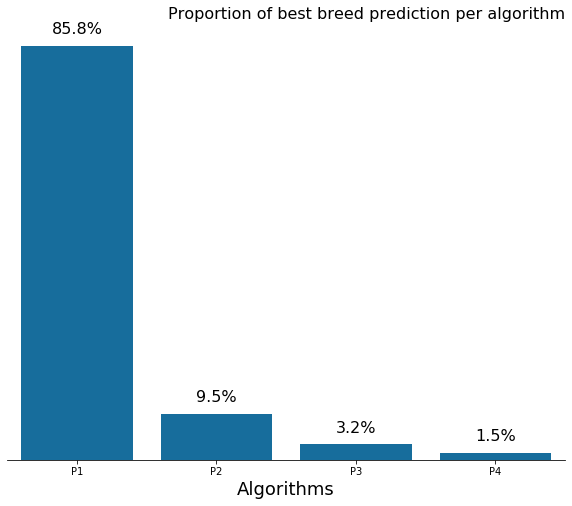

In [220]:
rcParams['figure.figsize'] = 10,8

base_color = sns.color_palette("colorblind")[0]

sns.countplot(data=image_predictions_clean, x='best_prediction', color=base_color);  

for i in range(best_prediction_count.shape[0]):
    count = best_prediction_count[i]
    pct_string = '{:.1f}%'.format(100*count/image_predictions_clean.shape[0])
    plt.text(i, count+50, pct_string, ha='center', size = 16)
plt.xlabel('Algorithms', size=18);

plt.ylabel('')
plt.yticks([],[])

plt.title('Proportion of best breed prediction per algorithm', size=16, loc='right')

sns.despine(left=True)

**`Insight 2:`** Is the length of Tweets's `text` log-normal distributed? 

In [221]:
# compute text length and store it in text_length dataframe

text_length = pd.DataFrame(columns=['length'])
text_length['length']= archive_clean.text.str.len()
text_length.head()

,length
0,85
1,138
2,121
3,79
4,138


In [222]:
non_null_text_length = text_length.query('length != 0')

In [223]:
non_null_text_length.describe()

,length
count,2058.000000
mean,97.913994
std,25.914164
min,12.000000
25%,81.000000
50%,107.000000
75%,115.000000
max,143.000000


Text(0.5, 0, 'length')

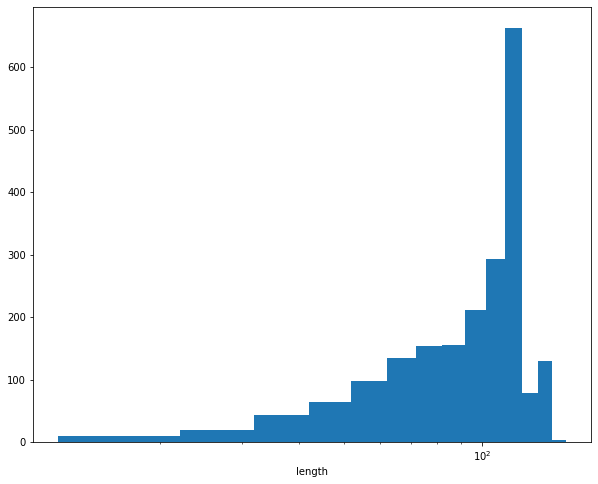

In [224]:
# plot histogram of text_length
base_color = sns.color_palette("colorblind")[0]
bins = np.arange(12, non_null_text_length['length'].max()+10, 10)
plt.hist(data=non_null_text_length, x='length', bins=bins);
plt.xscale('log')
plt.xlabel('length')

**`Insight 3:`** How `retweet_count` relates to `favorite_count`?

In [225]:
archive_clean.retweet_count.describe()

count     2058.000000
mean      2515.208455
std       4393.774446
min         11.000000
25%        538.000000
50%       1187.500000
75%       2891.000000
max      75566.000000
Name: retweet_count, dtype: float64

In [226]:
archive_clean.favorite_count.describe()

count      2058.000000
mean       7815.854713
std       11815.204685
min           0.000000
25%        1483.500000
50%        3430.000000
75%        9740.750000
max      152665.000000
Name: favorite_count, dtype: float64

Text(0.5, 0, "WeRateDogs tweets' like count")

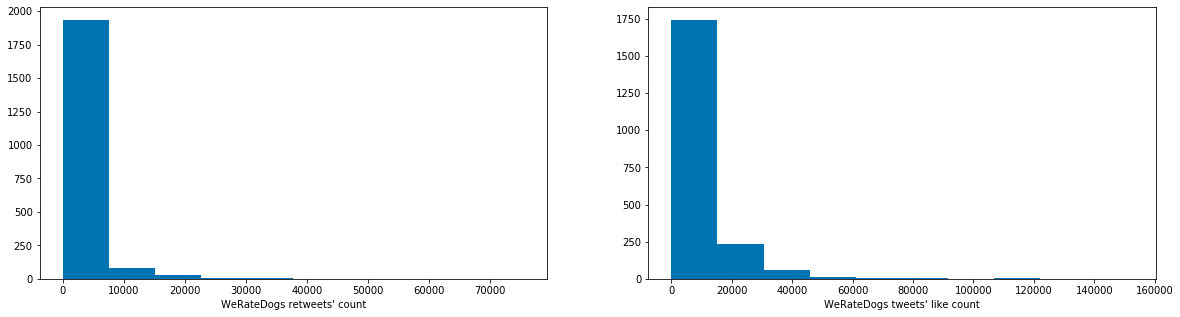

In [227]:
# plot histograms of retweet count and favorite count

# set fig size

plt.figure(figsize = [20, 5])
#color 
base_color = sns.color_palette("colorblind")[0]

# retweet count plot
plt.subplot(1, 2, 1) 
plt.hist(data=archive_clean, x='retweet_count', color=base_color);
plt.xlabel('WeRateDogs retweets\' count')

# favorite count color
plt.subplot(1, 2, 2) 
plt.hist(data=archive_clean, x='favorite_count', color=base_color);
plt.xlabel('WeRateDogs tweets\' like count')

In [228]:
archive_clean[archive_clean['retweet_count'] <= 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage


In [229]:
archive_clean[archive_clean['favorite_count'] <= 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,stage
32,885311592912609280,nan,nan,2017-07-13 01:35:06+00:00,Twitter for iPhone,RT @dog_rates: This is Lilly. She just paralle...,8.305833205850685e+17,4196983835.0,2017-02-12 01:04:29+00:00,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,16411,0,None
67,877611172832227328,nan,nan,2017-06-21 19:36:23+00:00,Twitter for iPhone,RT @rachel2195: @dog_rates the boyfriend and h...,8.76850772322988e+17,512804507.0,2017-06-19 17:14:49+00:00,https://twitter.com/rachel2195/status/87685077...,14,10,None,71,0,pupper
107,867072653475098625,nan,nan,2017-05-23 17:40:04+00:00,Twitter for iPhone,RT @rachaeleasler: these @dog_rates hats are 1...,8.650134204453683e+17,7.874617784352891e+17,2017-05-18 01:17:25+00:00,https://twitter.com/rachaeleasler/status/86501...,13,10,None,108,0,None
130,860924035999428608,nan,nan,2017-05-06 18:27:40+00:00,Twitter for iPhone,RT @tallylott: h*ckin adorable promposal. 13/1...,8.609144852504699e+17,363890752.0,2017-05-06 17:49:42+00:00,https://twitter.com/tallylott/status/860914485...,13,10,None,732,0,None
167,851861385021730816,nan,nan,2017-04-11 18:15:55+00:00,Twitter for iPhone,RT @eddie_coe98: Thanks @dog_rates completed m...,8.482893821761004e+17,341021133.0,2017-04-01 21:42:03+00:00,https://twitter.com/eddie_coe98/status/8482893...,10,10,None,19,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,754874841593970688,nan,nan,2016-07-18 03:06:01+00:00,Twitter for iPhone,RT @dog_rates: This is Rubio. He has too much ...,6.791583739888763e+17,4196983835.0,2015-12-22 04:35:49+00:00,https://twitter.com/dog_rates/status/679158373...,11,10,Rubio,7732,0,None
762,752309394570878976,nan,nan,2016-07-11 01:11:51+00:00,Twitter for iPhone,RT @dog_rates: Everyone needs to watch this. 1...,6.75354435921576e+17,4196983835.0,2015-12-11 16:40:19+00:00,https://twitter.com/dog_rates/status/675354435...,13,10,None,15844,0,None
1022,711998809858043904,nan,nan,2016-03-21 19:31:59+00:00,Twitter for iPhone,RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119982797733478e+17,783214.0,2016-03-21 19:29:52+00:00,https://twitter.com/twitter/status/71199827977...,12,10,None,123,0,None
1963,667550904950915073,nan,nan,2015-11-20 03:51:52+00:00,Twitter Web Client,RT @dogratingrating: Exceptional talent. Origi...,6.675486956640707e+17,4296831739.0,2015-11-20 03:43:06+00:00,https://twitter.com/dogratingrating/status/667...,12,10,None,31,0,None


#### Let's try plotting the square-root transformation of retweet_count and favorite_count 

In [230]:
def sqrt_trans(x, inverse = False):
    """ transformation helper function """
    if not inverse:
        return np.sqrt(x)
    else:
        return x ** 2

Text(0.5, 0, "WeRateDogs tweets' like count")

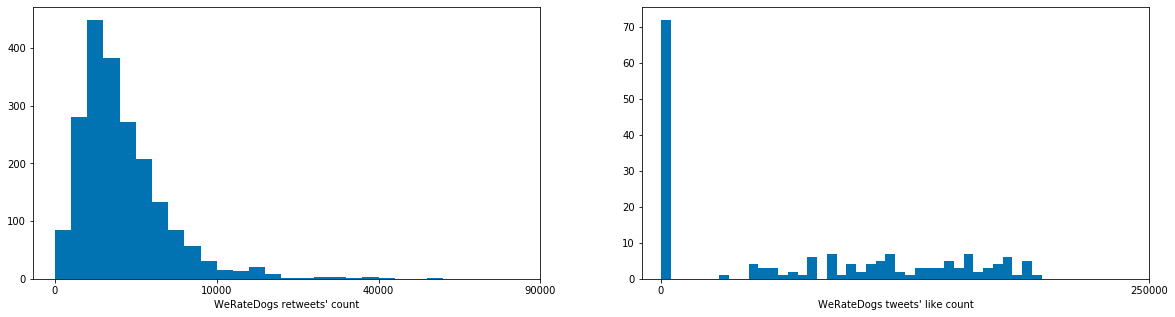

In [231]:
# plot histograms of retweet count and favorite count

# set fig size

plt.figure(figsize = [20, 5])

#color
base_color = sns.color_palette("colorblind")[0]

# retweet count plot
plt.subplot(1, 2, 1) 
bins = np.arange(0, sqrt_trans(archive_clean['retweet_count'].max()+10), 10)
plt.hist(archive_clean['retweet_count'].apply(sqrt_trans), color=base_color, bins=bins);

# Identify the tick-locations
tick_locs = np.arange(0, sqrt_trans(archive_clean['retweet_count'].max())+100, 100)

# Apply x-ticks
plt.xticks(tick_locs, sqrt_trans(tick_locs, inverse = True).astype(int));

plt.xlabel('WeRateDogs retweets\' count')

# favorite count plot
plt.subplot(1, 2, 2) 
bins = np.arange(0, sqrt_trans(archive_clean['favorite_count'].max()+10), 10)
plt.hist(data=archive_clean, x='favorite_count', color=base_color, bins=bins);

# Identify the tick-locations
tick_locs = np.arange(0, sqrt_trans(archive_clean['favorite_count'].max())+500, 500)

# Apply x-ticks
plt.xticks(tick_locs, sqrt_trans(tick_locs, inverse = True).astype(int));

plt.xlabel('WeRateDogs tweets\' like count')

In [232]:
archive_clean[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,2058.000000,2058.000000
mean,2515.208455,7815.854713
std,4393.774446,11815.204685
min,11.000000,0.000000
25%,538.000000,1483.500000
50%,1187.500000,3430.000000
75%,2891.000000,9740.750000
max,75566.000000,152665.000000


#### Let's plot scatterplot and heat map to figure out how retweet_count relates to favorite count

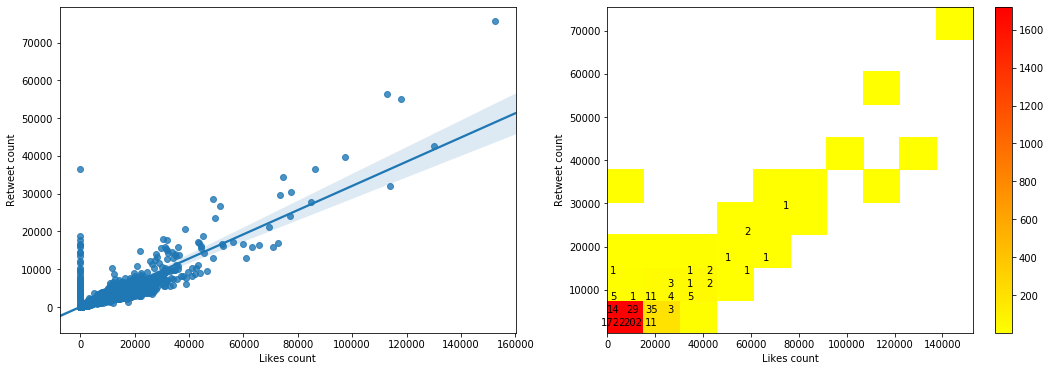

In [233]:
plt.figure(figsize = [18, 6])

#color
base_color = sns.color_palette("colorblind")[0]

# Scatter plot favorite_count on x axis and retweet_count on y axis (on left)
plt.subplot(1, 2, 1)

sns.regplot(data=archive_clean, x='favorite_count', y='retweet_count');
plt.xlabel('Likes count')
plt.ylabel('Retweet count')

# Heat map favorite_count on x axis and retweet_count on y axis
# cmap to reverse the color map.
# cmin specifies the minimum value in a cell before it will be plotted
plt.subplot(1, 2, 2)

# bin edges 
bins_x = np.arange(0, 152893+8000, 8000)
bins_y = np.arange(11, 75683+3000, 3000)

h2d = plt.hist2d(data=archive_clean, x='favorite_count', y='retweet_count', cmap='autumn_r', cmin=1);
plt.colorbar()
plt.xlabel('Likes count')
plt.ylabel('Retweet count')

# Select the bi-dimensional histogram, a 2D array of samples x and y. 
# Values in x are histogrammed along the first dimension and 
# values in y are histogrammed along the second dimension.
counts = h2d[0]

# average of retweet_count's mean and favorite_count's mean
avg_retweet_favorite = (archive_clean.retweet_count.mean() + archive_clean.retweet_count.mean()) / 2

# Add text annotation on each cell
# Loop through the cell counts and add text annotations for each

for i in range(counts.shape[0]):
    
    for j in range(counts.shape[1]):
        
        c = counts[i,j]
        
        if c >= avg_retweet_favorite: # increase visibility on darker cells
            
            plt.text(bins_x[i]+avg_retweet_favorite, bins_y[j]+avg_retweet_favorite, int(c),
                     
                     ha = 'center', va = 'center', color = 'white')
            
        elif c > 0:
            
            plt.text(bins_x[i]+avg_retweet_favorite, bins_y[j]+avg_retweet_favorite, int(c),
                     
                     ha = 'center', va = 'center', color = 'black')

**`Insight 4:`** How dogs stage relates to favorite count? 

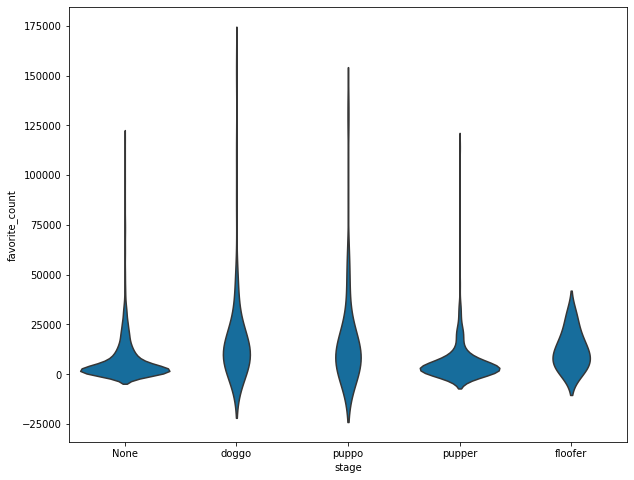

In [234]:
# color
base_color = sns.color_palette("colorblind")[0]

sns.violinplot(data=archive_clean, x='stage', y='favorite_count', color=base_color, inner = None);